In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.datasets

import h5py
import zipfile
import imageio
import os
from tqdm import tqdm
import pandas
import numpy
import random
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("using cuda:", torch.cuda.get_device_name(0))
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

float_tensor_fn = torch.cuda.FloatTensor if torch.cuda.is_available else torch.FloatTensor

using cuda: NVIDIA GeForce RTX 3090


In [3]:
hdf5_file = './dataset/celeba/celeba_aligned_small.h5py'

In [4]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data

def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

def crop_centre(img, new_width, new_height):
    height, width, _ = img.shape
    startx = width//2 - new_width//2
    starty = height//2 - new_height//2    
    return img[  starty:starty + new_height, startx:startx + new_width, :]

In [5]:
torchvision.datasets.CelebA(root='./dataset/', download=True)

Files already downloaded and verified


Dataset CelebA
    Number of datapoints: 162770
    Root location: ./dataset/
    Target type: ['attr']
    Split: train

In [6]:
if not os.path.exists(hdf5_file):
    count = 0
    
    with h5py.File(hdf5_file, 'w') as hf:
        with zipfile.ZipFile('./dataset/celeba/img_align_celeba.zip', 'r') as zf:
            for i in zf.namelist():
                print(i)
                if (i[-4:] == '.jpg'):
                    ofile = zf.extract(i)
                    img = imageio.imread(ofile)
                    os.remove(ofile)

                    hf.create_dataset('img_align_celeba/'+str(count)+'.jpg', data=img, compression="gzip", compression_opts=9)

                    count = count + 1
                    if (count%1000 == 0):
                        print("images done .. ", count)

In [7]:
class CelebADataset(Dataset):
    def __init__(self, file):        
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']
        pass
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        if (index >= len(self.dataset)):
            raise IndexError()
            
        img = numpy.array(self.dataset[str(index)+'.jpg'])
        return float_tensor_fn(img) / 255.0
    
    def plot_image(self, index):
        plt.imshow(numpy.array(self.dataset[str(index)+'.jpg']), interpolation='nearest')
        pass
    
    def __getitem__(self, index):
        if (index >= len(self.dataset)):
            raise IndexError()
        img = numpy.array(self.dataset[str(index)+'.jpg'])

        img = crop_centre(img, 128, 128)
        return float_tensor_fn(img).permute(2, 0, 1).view(1, 3, 128, 128) / 255.0
    
    def plot_image(self, index):
        img = numpy.array(self.dataset[str(index)+'.jpg'])
        img = crop_centre(img, 128, 128)
        plt.imshow(img, interpolation='nearest')
        pass    

In [8]:
caleba_dataset = CelebADataset(hdf5_file)

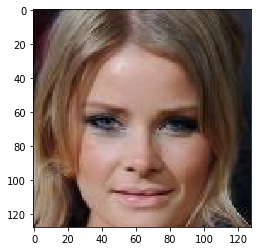

In [9]:
caleba_dataset.plot_image(9)

## Discriminator

In [10]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.GELU(),
            
            nn.Conv2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.GELU(),
            
            nn.Conv2d(256, 3, kernel_size=8, stride=2),
            nn.GELU(),
            
            View(3*10*10),
            nn.Linear(3*10*10, 1),
            nn.Sigmoid()
        )

        self.loss_function = nn.BCELoss()

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)

        self.counter = 0
        self.progress = []
        pass
    
    def forward(self, inputs):
        return self.model(inputs)
    
    def train(self, inputs, targets):
        outputs = self.forward(inputs)
        
        loss = self.loss_function(outputs, targets)
        
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        pass
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass

In [12]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(100, 3*11*11),
            nn.GELU(),
            
            View((1, 3, 11, 11)),
            
            nn.ConvTranspose2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.GELU(),

            nn.ConvTranspose2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.GELU(),

            nn.ConvTranspose2d(256, 3, kernel_size=8, stride=2, padding=1),
            nn.BatchNorm2d(3),
            
            nn.Sigmoid()
        )
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        
        self.counter = 0
        self.progress = []
        
    def forward(self, inputs):
        return self.model(inputs)
    
    def train(self, D, inputs, targets):
        g_output = self.forward(inputs)
        
        d_output = D.forward(g_output)
        
        loss = D.loss_function(d_output, targets)
        
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        pass        
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass    

In [13]:
%%time

D = Discriminator()
D.to(device)
G = Generator()
G.to(device)

for _ in tqdm(range(1)):

    for image_data_tensor in caleba_dataset:
        # Train 'true' images
        D.train(image_data_tensor, float_tensor_fn([1.0]))

        # Train 'false'
        D.train(G.forward(generate_random_seed(100)).detach(), float_tensor_fn([0.0]))

        # Train Generator
        G.train(D, generate_random_seed(100), float_tensor_fn([1.0]))

        pass

  0%|                                                                                                                                                                                                                                                                                                                              | 0/1 [00:00<?, ?it/s]

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
counter =  250000
counter =  260000
counter =  270000
counter =  280000
counter =  290000
counter =  300000
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000
counter =  360000
counter =  370000
counter =  380000
counter =  390000
counter =  400000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [1:25:23<00:00, 5123.47s/it]

Wall time: 1h 25min 23s


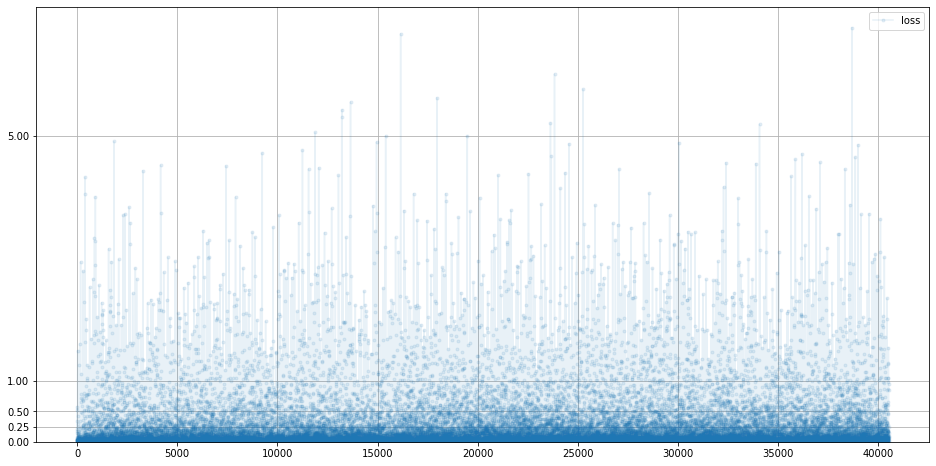

In [14]:
D.plot_progress()

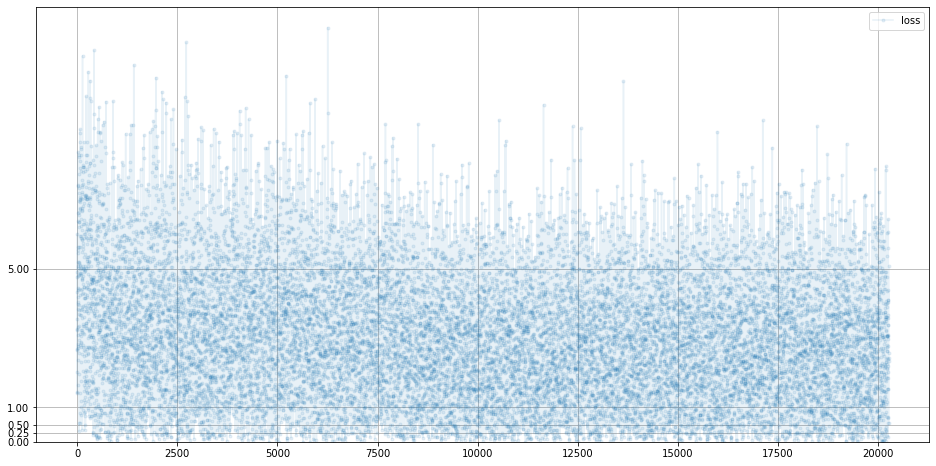

In [15]:
G.plot_progress()

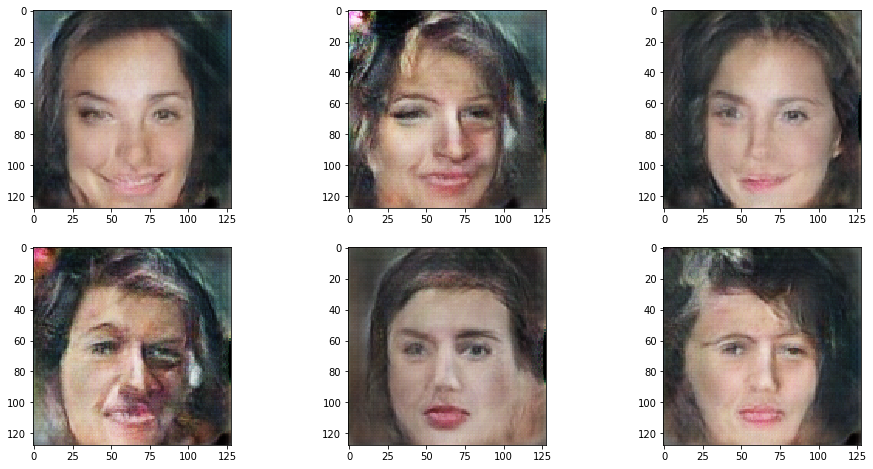

In [16]:
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().permute(0, 2, 3, 1).view(128, 128, 3).cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')